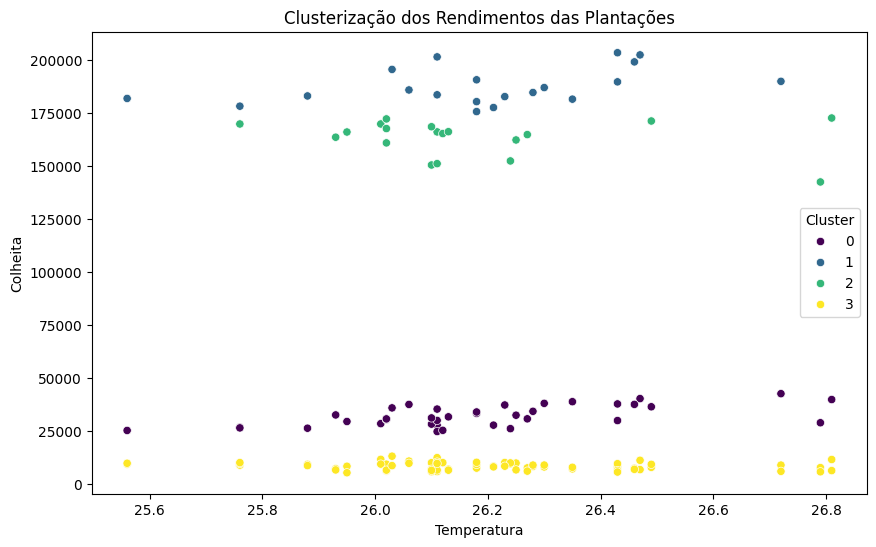

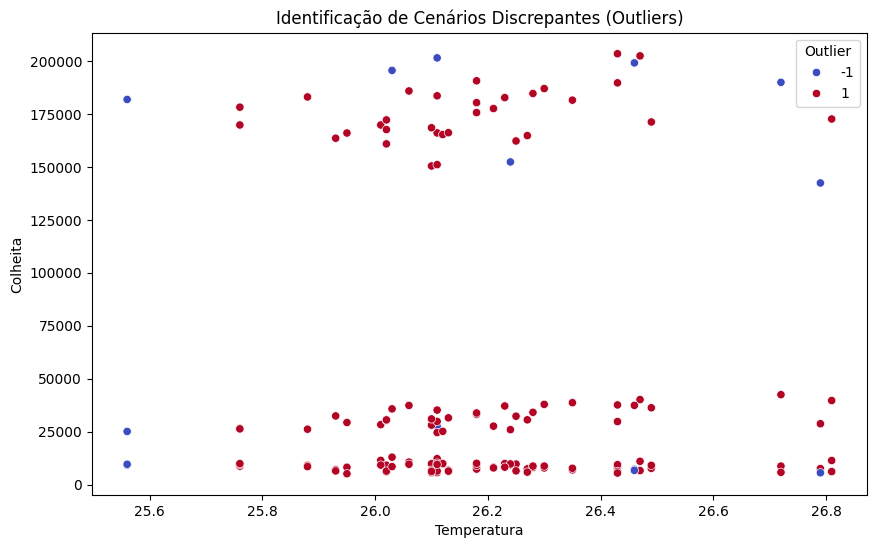


Identificação de Cenários Discrepantes (Outliers):
             Cultura  Cultura_encoded  Precipitacao  Humidade  \
1       Cocoa, beans                0       1938.42     17.54   
3       Cocoa, beans                0       2592.35     17.61   
36      Cocoa, beans                0       2967.41     18.67   
40    Oil palm fruit                1       1938.42     17.54   
41    Oil palm fruit                1       2301.54     17.81   
42    Oil palm fruit                1       2592.35     17.61   
56    Oil palm fruit                1       2362.80     18.70   
66    Oil palm fruit                1       3085.79     18.34   
75    Oil palm fruit                1       2967.41     18.67   
77    Oil palm fruit                1       2109.34     18.51   
79       Rice, paddy                2       1938.42     17.54   
81       Rice, paddy                2       2592.35     17.61   
118  Rubber, natural                3       1938.42     17.54   
120  Rubber, natural                3 

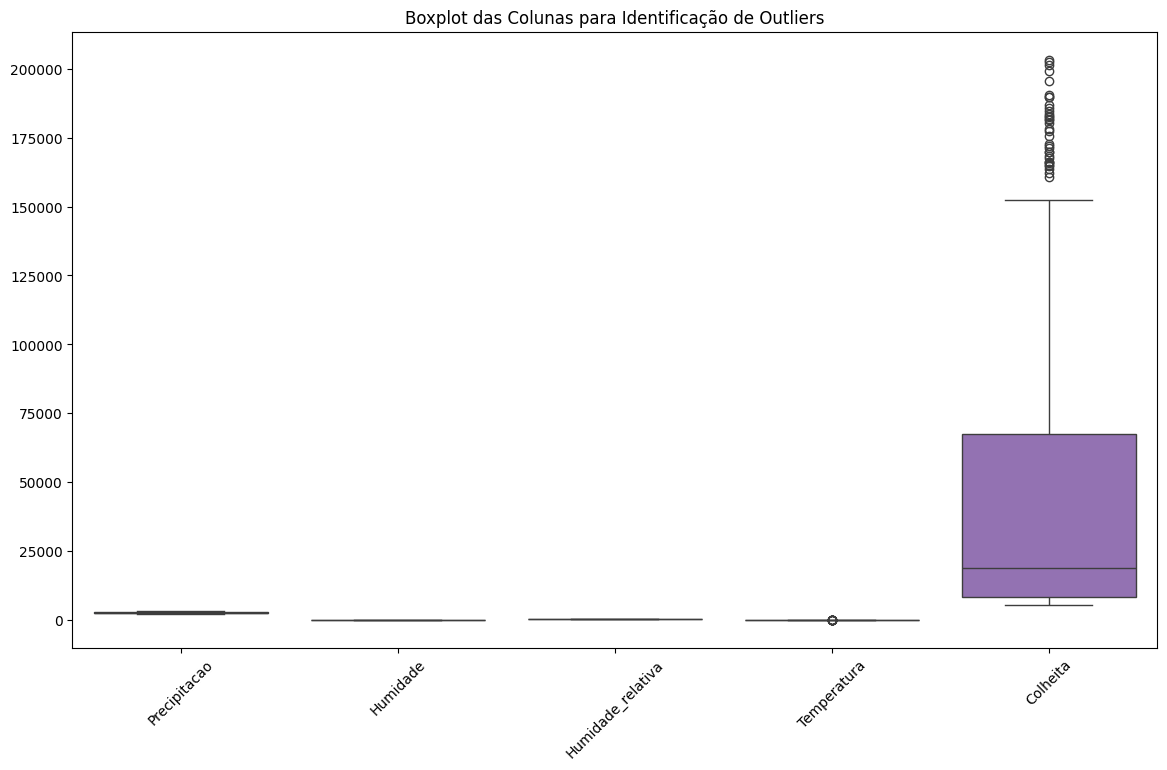


Estatísticas descritivas para cada coluna:
       Precipitacao    Humidade  Humidade_relativa  Temperatura       Colheita
count    156.000000  156.000000         156.000000    156.00000     156.000000
mean    2486.498974   18.203077          84.737692     26.18359   56153.096154
std      289.457914    0.293923           0.996226      0.26105   70421.958897
min     1934.620000   17.540000          82.110000     25.56000    5249.000000
25%     2302.990000   18.030000          84.120000     26.02000    8327.750000
50%     2424.550000   18.270000          84.850000     26.13000   18871.000000
75%     2718.080000   18.400000          85.510000     26.30000   67518.750000
max     3085.790000   18.700000          86.100000     26.81000  203399.000000

Avaliação do modelo: Linear Regression
Root Mean Squared Error (RMSE) for LinearRegression: 65364.56901634609
R² for LinearRegression: -0.10145864648572878


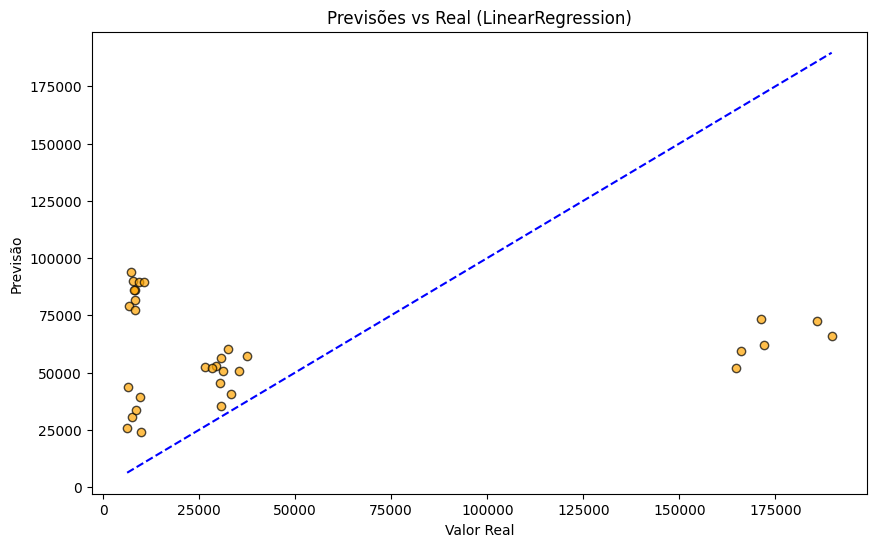


Avaliação do modelo: Decision Tree
Root Mean Squared Error (RMSE) for DecisionTreeRegressor: 5513.591283705204
R² for DecisionTreeRegressor: 0.9921629515631458


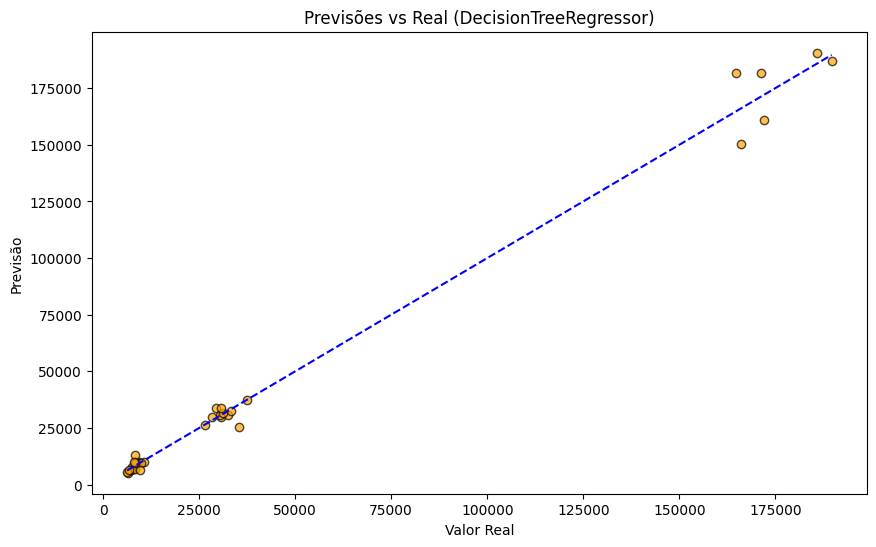


Avaliação do modelo: SVM
Root Mean Squared Error (RMSE) for SVR: 71312.75791075568
R² for SVR: -0.31104578138210703


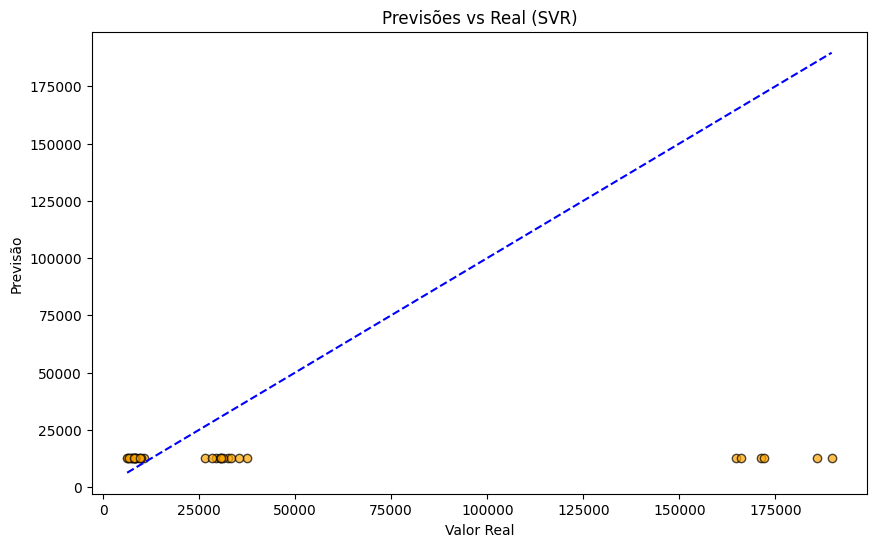


Avaliação do modelo: KNN
Root Mean Squared Error (RMSE) for KNeighborsRegressor: 35675.868050599
R² for KNeighborsRegressor: 0.6718801604527653


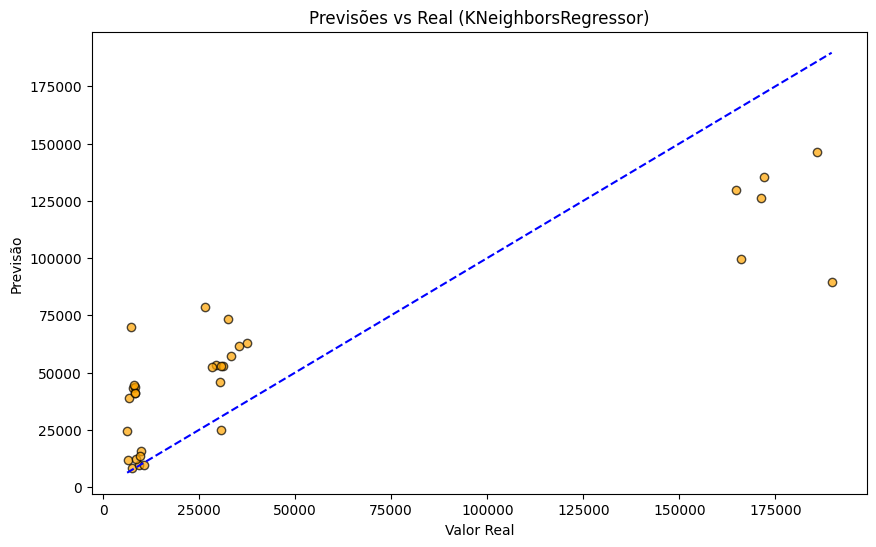


Avaliação do modelo: XGBoost
Root Mean Squared Error (RMSE) for XGBRegressor: 6293.051723925364
R² for XGBRegressor: 0.9897904396057129


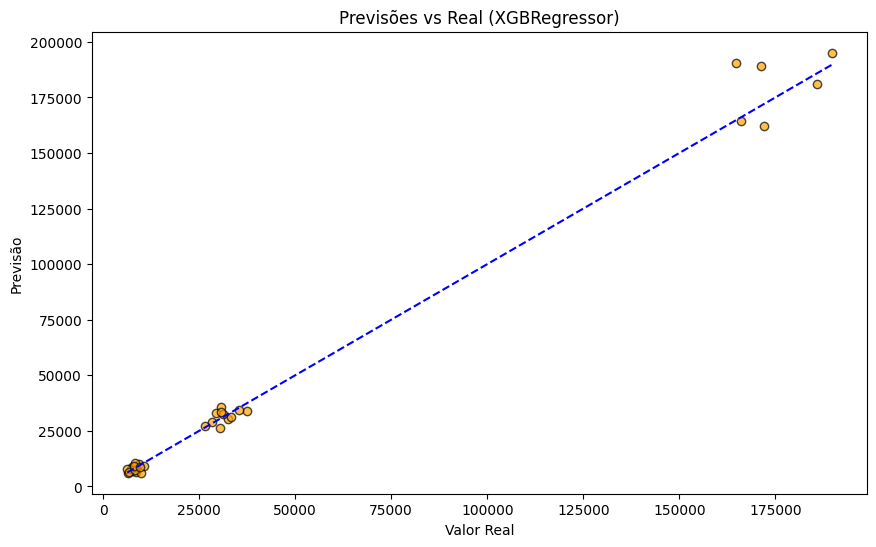


Classificação dos Modelos com base no RMSE (do melhor para o pior):
1. Decision Tree: RMSE = 5513.591283705204
2. XGBoost: RMSE = 6293.051723925364
3. KNN: RMSE = 35675.868050599
4. Linear Regression: RMSE = 65364.56901634609
5. SVM: RMSE = 71312.75791075568

Classificação dos Modelos com base no R² (do melhor para o pior):
1. Decision Tree: R² = 0.9921629515631458
2. XGBoost: R² = 0.9897904396057129
3. KNN: R² = 0.6718801604527653
4. Linear Regression: R² = -0.10145864648572878
5. SVM: R² = -0.31104578138210703


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Carregar o arquivo CSV
df = pd.read_csv('crop_yield.csv')

# Codificar a coluna 'Cultura' para valores numéricos usando Label Encoding
le = LabelEncoder()
df['Cultura_encoded'] = le.fit_transform(df['Cultura'])

# Excluir a coluna 'Cultura' original da análise de clusterização
data = df[['Precipitacao', 'Humidade', 'Humidade_relativa', 'Temperatura', 'Colheita', 'Cultura_encoded']]

# Realizar a clusterização usando KMeans com 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0)
df['Cluster'] = kmeans.fit_predict(data)

# Visualizar os clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperatura', y='Colheita', hue='Cluster', data=df, palette='viridis')
plt.title('Clusterização dos Rendimentos das Plantações')
plt.xlabel('Temperatura')
plt.ylabel('Colheita')
plt.show()

# Identificar cenários discrepantes (outliers) usando Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=0)
df['Outlier'] = iso_forest.fit_predict(data)

# Visualizar os outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperatura', y='Colheita', hue='Outlier', data=df, palette='coolwarm')
plt.title('Identificação de Cenários Discrepantes (Outliers)')
plt.xlabel('Temperatura')
plt.ylabel('Colheita')
plt.show()

# Exibir os resultados dos outliers (cenários discrepantes)
print("\nIdentificação de Cenários Discrepantes (Outliers):")
print(df[df['Outlier'] == -1][['Cultura', 'Cultura_encoded', 'Precipitacao', 'Humidade', 'Humidade_relativa', 'Temperatura', 'Colheita']])

# Boxplot para visualizar outliers nas variáveis
plt.figure(figsize=(14, 8))
sns.boxplot(data=df[['Precipitacao', 'Humidade', 'Humidade_relativa', 'Temperatura', 'Colheita']])
plt.title('Boxplot das Colunas para Identificação de Outliers')
plt.xticks(rotation=45)
plt.show()

# Exibindo as estatísticas descritivas para cada coluna numérica
print("\nEstatísticas descritivas para cada coluna:")
print(df[['Precipitacao', 'Humidade', 'Humidade_relativa', 'Temperatura', 'Colheita']].describe())

# Dividir os dados em features e target (Colheita é o alvo)
X = df[['Precipitacao', 'Humidade', 'Humidade_relativa', 'Temperatura', 'Cultura_encoded']]
y = df['Colheita']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados (opcional, mas recomendado para alguns modelos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Função para avaliar o modelo
def avaliar_modelo(modelo, X_train, X_test, y_train, y_test):
    # Treinar o modelo
    modelo.fit(X_train, y_train)

    # Fazer previsões
    y_pred = modelo.predict(X_test)

    # Calcular o RMSE manualmente
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error (RMSE) for {modelo.__class__.__name__}: {rmse}")

    # Calcular o R²
    r2 = r2_score(y_test, y_pred)
    print(f"R² for {modelo.__class__.__name__}: {r2}")

    # Plotando o gráfico de dispersão das previsões versus valores reais
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k", color='orange')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')
    plt.title(f"Previsões vs Real ({modelo.__class__.__name__})")
    plt.xlabel("Valor Real")
    plt.ylabel("Previsão")
    plt.show()

    return rmse, r2  # Retorna o RMSE e o R² para classificação posterior

# Modelos para testar
modelos = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "SVM": SVR(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror')
}

# Avaliar cada modelo e armazenar o RMSE e R²
resultados_rmse = []
resultados_r2 = []

for nome, modelo in modelos.items():
    print(f"\nAvaliação do modelo: {nome}")
    rmse, r2 = avaliar_modelo(modelo, X_train_scaled, X_test_scaled, y_train, y_test)
    resultados_rmse.append((nome, rmse))  # Armazenando o nome e o RMSE
    resultados_r2.append((nome, r2))  # Armazenando o nome e o R²

# Classificar os modelos com base no RMSE (do melhor para o pior)
resultados_rmse.sort(key=lambda x: x[1])  # Ordena pelo RMSE, do menor para o maior

# Classificar os modelos com base no R² (do melhor para o pior)
resultados_r2.sort(key=lambda x: x[1], reverse=True)  # Ordena pelo R², do maior para o menor

# Exibir a classificação baseada no RMSE
print("\nClassificação dos Modelos com base no RMSE (do melhor para o pior):")
for i, (nome, rmse) in enumerate(resultados_rmse, 1):
    print(f"{i}. {nome}: RMSE = {rmse}")

# Exibir a classificação baseada no R²
print("\nClassificação dos Modelos com base no R² (do melhor para o pior):")
for i, (nome, r2) in enumerate(resultados_r2, 1):
    print(f"{i}. {nome}: R² = {r2}")
